In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import PanelOLS
from pystout import pystout

In [2]:
# load data
df = pd.read_csv("data/data_win.csv")

df = df[(df.year_month > '2001-12') & (df.year_month < '2022-01')]

## 1. Green-Brown Portfolio

In [3]:
# construct greeness with co2_total
df['greenness_1'] = df.groupby('year_month')['Co2_tot'].transform(lambda x: pd.qcut(x, q=3, labels=range(1,4)))

# compute weights
df['mc_sum_1'] = df.groupby(['year_month', 'greenness_1']).Marketcap.transform('sum')
df['weights_1'] = df.Marketcap / df.mc_sum_1

# value weighted returns
df['vw_return_1'] = df.RET * df.weights_1

# value weighted return for portfolios with different greenness
vw_return_1 = df.groupby(['year_month', 'greenness_1'])['vw_return_1'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_1_wide = vw_return_1.pivot(index='year_month', columns='greenness_1', values='vw_return_1').reset_index()

vw_return_1_wide.columns = ['year_month', 'Green', 'netural_1', 'Brown']

# green-brown portfolio
vw_return_1_wide['Green_Brown'] = vw_return_1_wide['Green'] - vw_return_1_wide['Brown']

# load data
index_ = pd.read_csv('data/raw_data/index.csv')
index_['year_month'] = pd.PeriodIndex(index_.year_month, freq='M').astype(str)

# merge data
green_brown_1 = pd.merge(vw_return_1_wide, index_, how='inner')

In [4]:
# construct greeness with intensity
df['greenness_2'] = df.groupby('year_month')['Intensity_tot'].transform(lambda x: pd.qcut(x, q=3, labels=range(1,4)))

# compute weights
df['mc_sum_2'] = df.groupby(['year_month', 'greenness_2']).Marketcap.transform('sum')
df['weights_2'] = df.Marketcap / df.mc_sum_2

# value weighted returns
df['vw_return_2'] = df.RET * df.weights_2

# value weighted return for portfolios with different greenness
vw_return_2 = df.groupby(['year_month', 'greenness_2'])['vw_return_2'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_2_wide = vw_return_2.pivot(index='year_month', columns='greenness_2', values='vw_return_2').reset_index()

vw_return_2_wide.columns = ['year_month', 'Green', 'netural', 'Brown']

# green-brown portfolio
vw_return_2_wide['Green_Brown'] = vw_return_2_wide['Green'] - vw_return_2_wide['Brown']

# merge data
green_brown_2 = pd.merge(vw_return_2_wide, index_, how='inner')

In [5]:
# green-brown based on CO2 emission
# model 1 with only intercept
model1 = sm.OLS.from_formula('Green_Brown ~ 1', data=green_brown_1)
fit1 = model1.fit()

# model 2 with ff3 factors
model2 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML', data=green_brown_1)
fit2 = model2.fit()

# model 3 with ff5 factors
model3 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML + RMW + CMA', data=green_brown_1)
fit3 = model3.fit()

# green-brown based on Intensity
# model 4 with only intercept
model4 = sm.OLS.from_formula('Green_Brown ~ 1', data=green_brown_2)
fit4 = model4.fit()

# model 5 with ff3 factors
model5 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML', data=green_brown_2)
fit5 = model5.fit()

# model 6 with ff5 factors
model6 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML + RMW + CMA', data=green_brown_2)
fit6 = model6.fit()

In [6]:
# export the regression result
pystout(models=[fit1, fit2, fit3, fit4, fit5, fit6], 
        file='analysis_result/green-brown1.tex',
        varlabels={'const':'Constant','displacement':'Disp','mpg':'MPG'},
        stars = {.1:'*',.05:'**',.01:'***'},
        digits=3,
        modstat={'nobs':'Obs','rsquared':'R-squared'},
        mgroups={'CO2 Emission':[1,3], 'Intensity': [4,6]},
        addnotes=['* p\sym{<}.1, ** p\sym{<}.05, *** p\sym{<}.01'],
        title='Green - Brown Based on Total CO2 Emissions',
        label='green-brown1')

d:\software_installation\Python3.11.4\Lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
d:\software_installation\Python3.11.4\Lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))


### 1.2 With Climate Concern Index

In [7]:
index_ = pd.read_csv('data/raw_data/index.csv')
index_['year_month'] = pd.PeriodIndex(index_.year_month, freq='M').astype(str)

# shift columns
col_shift = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix']
index_[col_shift] = index_[col_shift].shift(1)

index_['mccc_lag1'] = index_.mccc.shift(1)

# drop nas
index_.dropna(inplace=True)

# use ARC model to get umc
arx_model = sm.OLS.from_formula('mccc ~ 1 + mccc_lag1 + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=index_)
arx_fit = arx_model.fit()

index_['umc'] = index_.mccc - arx_fit.predict()

index_ = index_[['year_month', 'umc']]

# merge
umc_merged = pd.merge(index_, green_brown_1, how='right')

In [8]:
# Green - Brown
model1 = sm.OLS.from_formula('Green_Brown ~ 1 + umc + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=umc_merged)
fit1 = model1.fit()

# Green
model2 = sm.OLS.from_formula('Green ~ 1 + umc + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=umc_merged)
fit2 = model2.fit()

# Green
model3 = sm.OLS.from_formula('Brown ~ 1 + umc + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=umc_merged)
fit3 = model3.fit()

# Neutral
model4 = sm.OLS.from_formula('netural_1 ~ 1 + umc + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=umc_merged)
fit4 = model4.fit()

In [9]:
# export the regression result
pystout(models=[fit1, fit2, fit3, fit4], 
        file='analysis_result/on_umc.tex',
        varlabels={'const':'Constant','displacement':'Disp','mpg':'MPG'},
        stars = {.1:'*',.05:'**',.01:'***'},
        digits=3,
        modstat={'nobs':'Obs','rsquared':'R-squared'},
        addnotes=['* p\sym{<}.1, ** p\sym{<}.05, *** p\sym{<}.01'],
        title='Green - Brown on UMC',
        label='tab: on_umc')

d:\software_installation\Python3.11.4\Lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
d:\software_installation\Python3.11.4\Lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))


## 2. Firm level analysis

In [10]:
# model with industry + time F.E.
# un restricted model
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data['Co2_tot'])

model1 = PanelOLS(dependent, exog, entity_effects=False, time_effects=True, other_effects=data['industry'])
fit1 = model1.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year_month']], low_memory=True)

# restricted model
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model2 = PanelOLS(dependent, exog, entity_effects=False, time_effects=True, other_effects=data['industry'])
fit2 = model2.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year_month']], low_memory=True)

In [11]:
# model with firm + time F.E.
# un restricted model
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data['Co2_tot'])

model3 = PanelOLS(dependent, exog, entity_effects=True, time_effects=True, other_effects=None)
fit3 = model3.fit(cov_type='clustered', cluster_entity=True, cluster_time=True, clusters=None, low_memory=True)

# restricted model
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model4 = PanelOLS(dependent, exog, entity_effects=True, time_effects=True, other_effects=None)
fit4 = model4.fit(cov_type='clustered', cluster_entity=True, cluster_time=True, clusters=None, low_memory=True)

In [12]:
# export the regression result
pystout(models=[fit1, fit2, fit3, fit4], 
        file='analysis_result/firm_level.tex',
        varlabels={'const':'Constant','displacement':'Disp','mpg':'MPG'},
        stars = {.1:'*',.05:'**',.01:'***'},
        digits=3,
        modstat={'nobs':'Obs','rsquared':'R-squared'},
        addnotes=['* p\sym{<}.1, ** p\sym{<}.05, *** p\sym{<}.01'],
        title='Firm Level Analysis',
        label='tab: firm_level')

d:\software_installation\Python3.11.4\Lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
d:\software_installation\Python3.11.4\Lib\site-packages\pystout\pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))


### 2.2 Change Fixed effects and cluster standard errors

In [13]:
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

# 1. benchmark model
model1 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO', 'year_month']])
fit1 = model1.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO', 'year_month']], low_memory=True)

# 2. only entity fixed effects
model2 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO']])
fit2 = model2.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO']], low_memory=True)

# 3. entity + year fixed effects
model3 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO', 'year']])
fit3 = model3.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO', 'year']], low_memory=True)

# 4. industry fixed effects
model4 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data['industry'])
fit4 = model4.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data['industry'], low_memory=True)

# 5. industry + year_month fixed effects
model5 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['industry', 'year_month']])
fit5 = model5.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year_month']], low_memory=True)

# 6. industry + year fixed effects
model6 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['industry', 'year']])
fit6 = model6.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year']], low_memory=True)

#########################################################
# 7. benchmark model + robust standard errors
model7 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO', 'year_month']])
fit7 = model7.fit()

# 8. benchmark model + cluster higher level 
model8 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO', 'year_month']])
fit8 = model8.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year']], low_memory=True)

In [14]:
results = []  # Initialize an empty list named 'results'

# Append the regression results strings to the 'results' list
results.append(fit1)
results.append(fit2)
results.append(fit3)
results.append(fit4)
results.append(fit5)
results.append(fit6)
results.append(fit7)
results.append(fit8)

In [15]:
temp = pd.DataFrame({'r': [results[i].params['Co2_tot'] for i in range(0,8)],
                    'p-val': [round(results[i].pvalues['Co2_tot'], 3) for i in range(0,8)],
                    'hl': [results[i].conf_int().iloc[1,1] for i in range(0,8)],
                    'll': [results[i].conf_int().iloc[1,0] for i in range(0,8)],
                    'std': [round(results[i].std_errors['Co2_tot'],3) for i in range(0,8)],
                    'power': [round(results[i].rsquared, 3) for i in range(0,8)],
                    'label': ['1. Benchmark model', '2. Entity F.E.', '3. Entity + Year F.E.', '4. Industry F.E.', '5. Industry + Year/Mon F.E.', '6. Industry +  Year F.E.', '7. Robust Standard Errors', '8. Industry + Year'],
                    'var': ['1. Benchmark model', '2. Entity F.E.', '3. Entity + Year F.E.', '4. Industry F.E.', '5. Industry + Year/Mon F.E.', '6. Industry +  Year F.E.', '7. Robust Standard Errors', '8. Industry + Year'],
                    'group': ['Benchmark', 'Fixed effects', 'Fixed effects', 'Fixed effects', 'Fixed effects', 'Fixed effects', 'Clustered standard errors', 'Clustered standard errors'],
                    'n': [(results[i].nobs) for i in range(0,8)]})

<Axes: xlabel='Regression coefficient'>

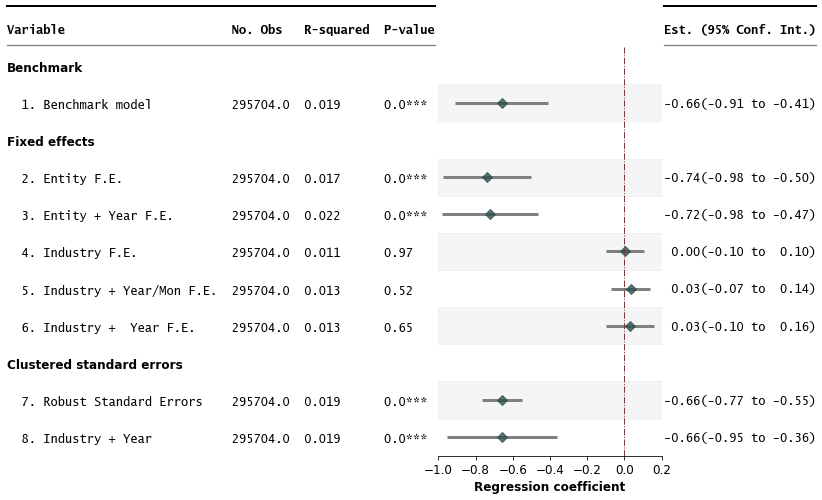

In [16]:
import forestplot as fp
fp.forestplot(temp,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              pval="p-val",  # column containing p-values to be formatted
              annote=['n', 'power', "formatted_pval"],  # columns to report on left of plot
              annoteheaders=['No. Obs', 'R-squared', "P-value"],  # ^corresponding headers
              rightannote=["est_ci"],  # columns to report on right of plot 
              right_annoteheaders=["Est. (95% Conf. Int.)"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=["Benchmark", "Fixed effects", "Clustered standard errors"],                   
              xlabel="Regression coefficient",  # x-label title
              xticks=[-1, -0.8, -0.6, -0.4, -0.2, 0, .2],  # x-ticks to be printed
              sort=False,  # sort estimates in ascending order
              color_alt_rows=True,  # Gray alternate rows
              table=True,  # Format as a table
              # Additional kwargs for customizations
              **{'fontfamily': 'monospace', # only font that align
                 "marker": "D",
                 "markersize": 50,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "firebrick",  # color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'linecolor': 'gray', # error bar line color
                 'lw': 3, # error bar line width
                 'xlinestyle': 'dashdot', # vertical line change
                 'xlinewidth': 1
                }  
              )

### 2.3 Interplay with climate concerns

In [17]:
# merge with UMC data
df = df.merge(index_, how='left')

# load data
index_all = pd.read_csv('data/raw_data/index.csv')
index_all['year_month'] = pd.PeriodIndex(index_all.year_month, freq='M').astype(str)

# merge data
df = pd.merge(df, index_all, how='inner')

In [18]:
# with market factor model
data = df[['PERMNO', 'year_month', 'year', 'RET', 'umc', 'Mkt_RF', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)
data['intersection'] = data.Co2_tot * data.umc

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'umc', 'intersection', 'Mkt_RF', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model1 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO']])
fit1 = model1.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO']], low_memory=True)

# with FF 3 factors model
data = df[['PERMNO', 'year_month', 'year', 'RET', 'umc', 'Mkt_RF', 'SMB', 'HML', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)
data['intersection'] = data.Co2_tot * data.umc

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'umc', 'intersection', 'Mkt_RF', 'SMB', 'HML', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model2 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO']])
fit2 = model2.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO']], low_memory=True)

# with FF 5 factors model
data = df[['PERMNO', 'year_month', 'year', 'RET', 'umc', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)
data['intersection'] = data.Co2_tot * data.umc

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'umc', 'intersection', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model3 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO']])
fit3 = model3.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO']], low_memory=True)

# with FF 5 factors and other indicators
data = df[['PERMNO', 'year_month', 'year', 'RET', 'umc', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)
data['intersection'] = data.Co2_tot * data.umc

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'umc', 'intersection', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model4 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO']])
fit4 = model4.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO']], low_memory=True)

In [19]:
# export the regression result
pystout(models=[fit1, fit2, fit3, fit4], 
        file='analysis_result/firm_umc.tex',
        varlabels={'const':'Constant','displacement':'Disp','mpg':'MPG'},
        stars = {.1:'*',.05:'**',.01:'***'},
        digits=3,
        modstat={'nobs':'Obs','rsquared':'R-squared'},
        addnotes=['* p\sym{<}.1, ** p\sym{<}.05, *** p\sym{<}.01'],
        title='Cross-section Stock Return with UMC',
        label='tab: firm_umc')

## Green-Brown Premium In Different Time Periods

In [ ]:
# Assuming 'year_month' is a string column containing dates in the format 'yyyy-mm-dd'
green_brown_1['year_month'] = pd.to_datetime(green_brown_1['year_month'])

# Now, you can extract the year
green_brown_1['year'] = green_brown_1['year_month'].dt.year